# 自动求导

深度学习框架通过自动计算导数，即自动微分（automatic differentiation）来加快求导。实际中，根据设计好的模型，系统会构建一个计算图（computational graph），来跟踪计算是那些数据通过哪些操作组合起来产生输出。自动微分使系统能够随后反向传播梯度。这里，反向传播（back propagate）意味着跟踪整个计算图，填充关于每个参数的偏导数。

## 1. 一个简单的例子

假设我们想对函数 $y=2x^{\top}x$ 关于列向量 $x$ 求导：

In [1]:
import torch

x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

在我们计算 y 关于 x 的梯度之前，我们需要一个地方来储存梯度：

In [2]:
x.requires_grad_(True)  # 等价于 x=torch.arange(4.0, requires_grad=True)
x.grad  # 默认是 None

现在让我们计算 $y$：

In [3]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

通过调用反向传播函数来自动计算 $y$ 关于 $x$ 每个分量的梯度：

In [4]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [5]:
x.grad == 4 * x

tensor([True, True, True, True])

现在让我们计算 $x$ 的另一个函数：

In [6]:
# 默认情况下， PyTorch 会累积梯度，我们需要清楚之前的值
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

## 2. 非标量变量的反向传播

当 $y$ 不是标量时，向量 $y$ 关于向量 $x$ 的导数的最自然解释是一个矩阵。对于高阶和高维的 $y$ 和 $x$，求导的结果可以是一个高阶张量。

深度学习中，当调用向量的反向计算时，我们通常会试图计算一批训练样本中每个组成部分的损失函数的导数。我们的目的不是计算微分矩阵，而是批量中每个样本单独计算的偏导数之和：

In [7]:
# 对非标量调用 backward 需要传入一个 gradient 参数，该参数指定微分函数关于 self 的梯度
# 本例只想求偏导数的和，所以传递一个 1 的梯度是合适的
x.grad.zero_()
y = x * x
# 等价于 y.backward(torch.ones(len(x)))
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

### backward() 方法中 gradient 参数的意义：

backward() 方法的作用是求出某个张量对于某些**标量**节点的梯度，当 $y$ 不是标量时，直接调用 backward() 方法会抛出 `Runtime Error: grad can be implicitly created only for scalar outputs`。

因此，如果 $y$ 是矩阵（或向量），要先把 $y$ 转化为标量，再求导。转化的方法是：backward() 函数传入一个矩阵 $m$，计算 ${y} \cdot {m}$（矩阵中的元素对应相乘再求和），就得到一个标量（实际上就是 $y$ 中的元素加权求和），然后才能求导。

举个例子：

设 $x = [x_1, x_2, x_3], z = x_1^2 + x_2^2 + x_3^2  + 6$，那么 `z.backword()` 表示的就是张量 $x$ 对于标量 $z$ 的梯度，即：$[\frac{\partial{z}}{\partial{x_1}}, \frac{\partial{z}}{\partial{x_2}}, \frac{\partial{z}}{\partial{x_3}}]$

In [8]:
x = torch.randn(size=((1, 3)), requires_grad=True)
y = x ** 2 + 2
z = torch.sum(y)
z.backward()
x, x.grad

(tensor([[-0.6000, -0.7555, -0.2983]], requires_grad=True),
 tensor([[-1.2000, -1.5111, -0.5966]]))

但是，当我们想对一个向量使用 backward() 的时候，就必须想办法让向量变为标量。

举个例子：

设

$$
x = [x_1, x_2, x_3], y = [y_1, y_2]
$$
$$
y_1 = x_1x_2x_3
$$
$$
y_2 = x_1 + x_2 + x_3
$$

在这里，我们使用一个函数 $a = g(y)$（先不关心函数的具体实现），来把变量 $y$ 变成一个标量，然后我们就可以对 $a$ 使用 backward()，表示张量 $x$ 对标量 $a$ 的梯度，即：$[\frac{\partial{a}}{\partial{x_1}}, \frac{\partial{a}}{\partial{x_2}}, \frac{\partial{a}}{\partial{x_3}}]$ .

从数学公式角度去理解：

$$
\frac{\partial{a}}{\partial{x_1}} = 
\frac{\partial{a}}{\partial{y_1}}\frac{\partial{y_1}}{\partial{x_1}} + 
\frac{\partial{a}}{\partial{y_2}}\frac{\partial{y_2}}{\partial{x_1}}
$$
$$
\frac{\partial{a}}{\partial{x_2}} = 
\frac{\partial{a}}{\partial{y_1}}\frac{\partial{y_1}}{\partial{x_2}} + 
\frac{\partial{a}}{\partial{y_2}}\frac{\partial{y_2}}{\partial{x_2}}
$$
$$
\frac{\partial{a}}{\partial{x_3}} = 
\frac{\partial{a}}{\partial{y_1}}\frac{\partial{y_1}}{\partial{x_3}} + 
\frac{\partial{a}}{\partial{y_2}}\frac{\partial{y_2}}{\partial{x_3}}
$$

写成矩阵形式即：

$$
[\frac{\partial{a}}{\partial{x_1}}, \frac{\partial{a}}{\partial{x_2}}, \frac{\partial{a}}{\partial{x_3}}] = 
[\frac{\partial{a}}{\partial{y_1}}, \frac{\partial{a}}{\partial{y_2}}]
\left[
\begin{array}{ccc}
\frac{\partial{y_1}}{\partial{x_1}} & \frac{\partial{y_1}}{\partial{x_2}} & \frac{\partial{y_1}}{\partial{x_3}} \\
\frac{\partial{y_2}}{\partial{x_1}} & \frac{\partial{y_2}}{\partial{x_2}} & \frac{\partial{y_2}}{\partial{x_3}} 
\end{array}
\right]
$$

其中，

$$
\left[
\begin{array}{ccc}
\frac{\partial{y_1}}{\partial{x_1}} & \frac{\partial{y_1}}{\partial{x_2}} & \frac{\partial{y_1}}{\partial{x_3}} \\
\frac{\partial{y_2}}{\partial{x_1}} & \frac{\partial{y_2}}{\partial{x_2}} & \frac{\partial{y_2}}{\partial{x_3}} 
\end{array}
\right]
$$

是可以计算得出的，而由于 $a = g(y)$ 函数未确定，所以 $[\frac{\partial{a}}{\partial{y_1}}, \frac{\partial{a}}{\partial{y_2}}]$ 是无法计算的。
 
其实 `gradient` 参数的作用就是定义出这个 $[\frac{\partial{a}}{\partial{y_1}}, \frac{\partial{a}}{\partial{y_2}}]$ 。

回到代码中：

In [9]:
x = torch.arange(3.0, requires_grad=True)

y = torch.randn(2) 
y[0] = x[0]*x[1]*x[2]
y[1] = x[0]+x[1]+x[2]

y.backward(torch.tensor([0.1, 0.2]))
x, x.grad

(tensor([0., 1., 2.], requires_grad=True), tensor([0.4000, 0.2000, 0.2000]))

## 3. 分离计算

有时，我们希望将某些计算移动到记录的计算图之外。例如，假设 $y$ 是作为 $x$ 的函数计算的，而 $z$ 则是作为 $y$ 和 $x$ 的函数计算的。想象一下，我们想计算 $z$ 关于 $x$ 的梯度，但由于某种原因，希望将 $y$ 视为一个常数，并且只考虑到 $x$ 在 $y$ 被计算后发挥的作用。

这里可以分离 $y$ 来返回一个新变量 $u$，该变量与 $y$ 具有相同的值，但丢弃计算图中如何计算 $y$ 的任何信息。换句话说，梯度不会向后流经 $u$ 到 $x$。因此，下面的反向传播函数计算 $z=u*x$ 关于 $x$ 的偏导数，同时将 $u$ 作为常数处理，而不是 $z=x*x*x$ 关于 $x$ 的偏导数。

In [10]:
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x

z.sum().backward()
x.grad, x.grad == u

(tensor([0., 1., 4.]), tensor([True, True, True]))

In [11]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True])

## 4. Python 控制流的梯度计算

即使构建函数的计算图需要通过 Python 控制流（例如，条件、循环或任意函数调用），我们仍然可以计算得到变量的梯度：

In [12]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()

a.grad == d / a

tensor(True)

## 5. 小结

深度学习框架可以自动计算导数：我们首先将梯度附加到想要对其计算偏导数的变量上，然后记录目标值的计算，执行它的反向传播函数，并访问得到的梯度。

## 6. 练习

1. 为什么计算二阶导数比一阶导数的开销要更大？

2. 在运行反向传播函数后，立即再次运行它，看看会发生什么。

In [13]:
x=torch.arange(4.0, requires_grad=True)
x

tensor([0., 1., 2., 3.], requires_grad=True)

In [14]:
y = 2 * torch.dot(x, x)
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [15]:
y.backward()
x.grad

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [16]:
x=torch.arange(4.0, requires_grad=True)
y = 2 * torch.dot(x, x)
y.backward(retain_graph=True)
x.grad

tensor([ 0.,  4.,  8., 12.])

In [17]:
y.backward(retain_graph=True)
x.grad

tensor([ 0.,  8., 16., 24.])

In [18]:
y.backward()
x.grad

tensor([ 0., 12., 24., 36.])

3. 在控制流的例子中，我们计算 d 关于 a 的导数，如果将变量 a 更改为随机向量或矩阵，会发生什么？

In [19]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

In [20]:
a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()

print(f'a: {a}')
print(f'd: {d}')
print(f'a.grad: {a.grad}')
print(f'd / a: {d / a}')

a: -0.013132723979651928
d: -172133.234375
a.grad: 13107200.0
d / a: 13107200.0


In [21]:
a = torch.randn(size=((6, 1)), requires_grad=True)
print(f'a.shape: {a.shape}')

d = f(a)
print(f'd.shape: {d.shape}')

# d.backward() -> grad can be implicitly created only for scalar outputs
d.backward(torch.ones(len(a),1))  # 等价于 d.sum().backward()
print(f'a.grad.shape: {a.grad.shape}')
print(f'd / a: {d / a}')

a.shape: torch.Size([6, 1])
d.shape: torch.Size([6, 1])
a.grad.shape: torch.Size([6, 1])
d / a: tensor([[102400.0000],
        [102400.0000],
        [102400.0000],
        [102400.0000],
        [102400.0000],
        [102400.0078]], grad_fn=<DivBackward0>)


In [22]:
a = torch.randn(size=((2,3)), requires_grad=True)
print(f'a.shape: {a.shape}')

d = f(a)
print(f'd.shape: {d.shape}')

# d.backward() -> grad can be implicitly created only for scalar outputs
d.backward(torch.ones(d.shape))  # 等价于 d.sum().backward()
print(f'a.grad.shape: {a.grad.shape}')
print(f'd / a: {d / a}')

a.shape: torch.Size([2, 3])
d.shape: torch.Size([2, 3])
a.grad.shape: torch.Size([2, 3])
d / a: tensor([[1024., 1024., 1024.],
        [1024., 1024., 1024.]], grad_fn=<DivBackward0>)


4. 重新设计一个求控制流梯度的例子，运行并分析结果。

In [23]:
def f(x):
    count = 0
    while x.norm() < 100:
        x = (x + 2) ** 2
        count += 1
    return x, count

def dx(x, count):
    if count == 0:
        return torch.ones(x.shape)
    r = 2 ** count
    m = x + 2
    for i in range(count):
        r = r * m
        m = m ** 2 + 2
    return r
    

a = torch.randn(size=(10,), requires_grad=True)
print(f'a: {a}')

d, count = f(a)
print(f'd: {d}')
print(f'count: {count}')

# d.backward() -> grad can be implicitly created only for scalar outputs
d.backward(torch.ones(d.shape))  # 等价于 d.sum().backward()
print(f'a.grad: {a.grad}')
print(f'd(x, count): {dx(a, count)}')
a.grad == dx(a, count)

a: tensor([-0.0625,  1.0725, -1.9651, -1.1932, -0.2193, -0.0090,  0.1104, -0.4684,
        -1.9621, -0.0152], requires_grad=True)
d: tensor([ 33.1075, 130.8838,   4.0049,   7.0271,  26.7376,  35.5710,  41.6495,
         18.8862,   4.0058,  35.2752], grad_fn=<PowBackward0>)
count: 2
a.grad: tensor([ 44.5928, 140.6044,   0.2797,   8.5545,  36.8306,  47.4988,  54.4782,
         26.6244,   0.3038,  47.1524])
d(x, count): tensor([ 44.5928, 140.6044,   0.2797,   8.5545,  36.8306,  47.4988,  54.4782,
         26.6244,   0.3038,  47.1524], grad_fn=<MulBackward0>)


tensor([True, True, True, True, True, True, True, True, True, True])

5. 使 $ f(x)=\sin{(x)}$，绘制 $f(x)$ 和 $\frac{df(x)}{dx}$ 的图像，其中后者不使用 $f'(x)=\cos{(x)}$。

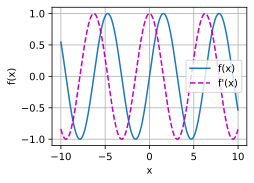

In [27]:
%matplotlib inline
from matplotlib_inline import backend_inline
from d2l import torch as d2l
import numpy as np
        
def f(x):
    return torch.sin(x)

x = torch.tensor(np.arange(-10, 10, 0.01), requires_grad=True)
y = f(x)
y.backward(torch.ones(y.shape))
d2l.plot(x.detach().numpy(), [f(x).detach().numpy(), x.grad.detach().numpy()], 'x', 'f(x)', legend=['f(x)', 'f\'(x)'])